# Exploring Inhibitory Post-Synaptic Shapes

In this tutorial we will explore some variations in post-synaptic shapes in the 6,805 predicted inhibitory neurons in the MICrONS dataset. The figures and data in this tutorial correspond to Figure 4 and Extended Data Figures 2-3 in Elabbady et al. 2024. For more details on the results and methods, please refer to the manuscript.

Briefly - for each cell, we extracted a small region around each post-synaptic synapse. This left us with a small mesh that encompassed a spine-like shape or part of a shaft, soma or axon. Each individual shape is what we refer to as a post-synaptic shape (PSS). This allows us to explore how inhibitory cell-types differ not only by the placement of synapses (how synapse density varies across a cell) but also by the fine morphologies at each given synapse (e.g. variations in spine-like shapes, different sized shafts etc.)

Below are three examples with the synapse shown as a blue point and the corresponding PSS highlighted in orange.

![](../files/PSS_example1.png){width=250} ![](../files/PSS_example2.png){width=250} ![](../files/PSS_example3.png){width=250} 

In [16]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import umap
%matplotlib inline

To start out, let's take a look at all the predicted inhibitory neurons in the dataset in the 2D UMAP embedding space. Note that this embedding only shows inhibitory neurons as it includes the nucleus, soma and 120 PSS features.

The following plot shows all the predicted inhibitory neurons in gray with the manually labeled cortical column cells in color (Fig. 4).

In [59]:
#reading in the data
df = pd.read_pickle('../data/inhibitory_perisomatic_feats_v661.pkl')

In [60]:
color_dict = {'23P':'#8268DC',
              '4P':'#647FDC',
              '5P-IT':'#77BCDE',
              '5P-ET':'#87DD90',
              '5P-NP':'#85DEC9',
              '6P-CT':'#96DD70',
              '6P-IT':'#DCC86E',
              'BC':'#D68C66',
              'BPC':'#D3697C',
              'MC':'#D36BBA',
              'NGC':'#BC6BDB',
              'astrocyte':'#009245',
              'pericyte':'#754C24',
              'microglia':'#006837',
              'oligo':'#8CC63F',
              'OPC':'#998675',
              'error':'#899499'
    
}

[]

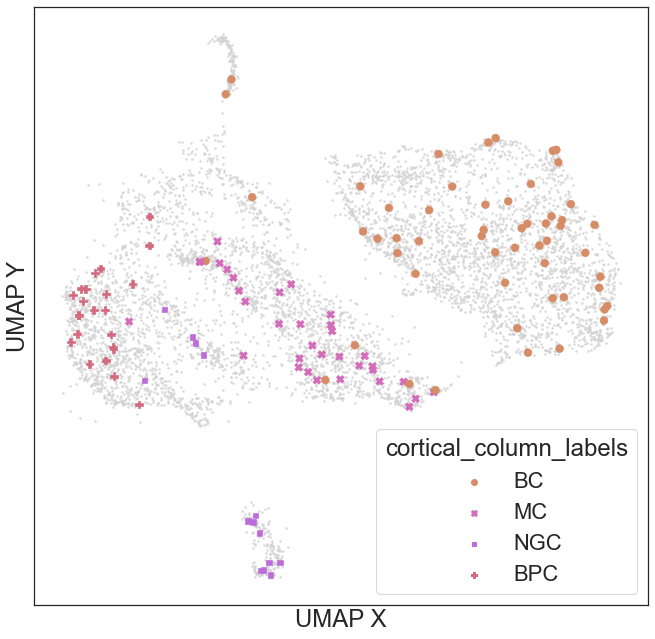

In [61]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', color='lightgray',
                ax =ax, s=5, alpha=0.9, edgecolor=None, data=df, legend = True)

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, s=60, alpha=1, hue='cortical_column_labels',style='cortical_column_labels',
                palette=color_dict, legend = True,
                c=(.2,.2,.2),edgecolor=None, data=df)

ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
ax.set_xticks([])
ax.set_yticks([])

For each neuron we can create a histogram of its PSS features like the example below. In this heatmap each row corresponds to a binned distance from the soma e.g. 0-15 microns from the soma center and each row corresponds to one of the 30 PSS bins (see manuscript methods for more detail)

Text(0.5, 1.0, 'PSS Histogram for Example Cell')

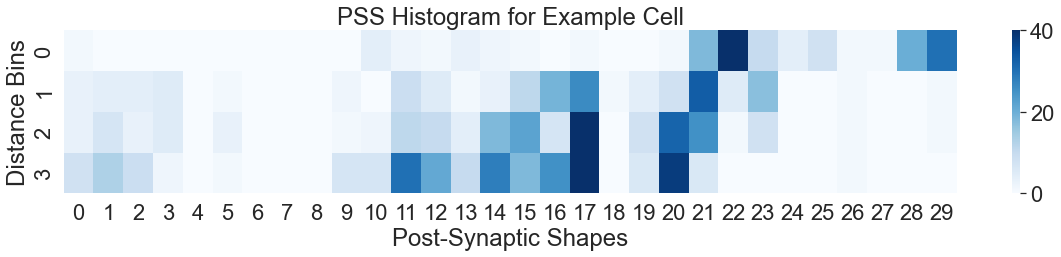

In [99]:
example_soma = 864691136020894968
pss_cols = [i for i in df.columns if 'shape' in i]
dist_bins = ['0_to_15000', '15000_to_30000','30000_to_45000','45000_to_60000']

sample = df.query('soma_id == @example_soma')
data = np.empty((1,30))

#reformatting the data into a numpy array
for d in dist_bins:
    d_cols = [i for i in pss_cols if d in i]
    row = sample[d_cols].to_numpy()
    data = np.concatenate([data,row])
data = data[1:,:]

fig, ax = plt.subplots(figsize=(20,3))
sns.heatmap(data,cmap='Blues',vmin=0,vmax=40.0)

ax.set_xlabel('Post-Synaptic Shapes')
ax.set_ylabel('Distance Bins')
ax.set_title('PSS Histogram for Example Cell')

Now let's take a look at how these histograms vary across all the inhibitory cells. To do this we need to restructure the data slightly, mainly we will do two things. 

1. We will compress the 30 shape bins into 5 shape classes: soma shapes, short spines, long spines, shafts, and spiny shafts

2. The current data is in number of synapses, we will normalize the data so that these numbers reflect the proportion of input synapses onto each shape class rather than the raw number.

#### Grouping by shape class

In [62]:
#Mapping features to overall shape classes 
shape_dict = {
    'short_spines' : [],
    'long_spines' : [],
    'soma' : [],
    'shaft' : [],
    'spiny_shaft': []
}

for i in df.columns:
    if 'shape' in i:
        shape_num = int(i.split('_')[1])
        if shape_num <6:
            c = shape_dict['short_spines']
            new_list = c + [i]
            shape_dict['short_spines'] = new_list
        elif shape_num <12:
            c = shape_dict['long_spines']
            new_list = c + [i]
            shape_dict['long_spines'] = new_list
        elif shape_num <18:
            c = shape_dict['shaft']
            new_list = c + [i]
            shape_dict['shaft'] = new_list
        elif shape_num <24:
            c = shape_dict['spiny_shaft']
            new_list = c + [i]
            shape_dict['spiny_shaft'] = new_list
        else:
            c = shape_dict['soma']
            new_list = c + [i]
            shape_dict['soma'] = new_list




In [63]:
#Aggregating the individual shape bins into shape classes e.g. short spines vs long spines

shape_columns = []

shape_list = shape_dict['soma']
for i in dist_bins:
    dist_bin = [col for col in shape_list if i in col]
    df['soma_%s'%(i)] = df[dist_bin].T.sum().tolist()
    shape_columns.append('soma_%s'%(i))
    
shape_list = shape_dict['short_spines']
for i in dist_bins:
    dist_bin = [col for col in shape_list if i in col]
    df['short_spines_%s'%(i)] = df[dist_bin].T.sum().tolist()
    shape_columns.append('short_spines_%s'%(i))
    
shape_list = shape_dict['long_spines']
for i in dist_bins:
    dist_bin = [col for col in shape_list if i in col]
    df['long_spines_%s'%(i)] = df[dist_bin].T.sum().tolist()
    shape_columns.append('long_spines_%s'%(i))
    
shape_list = shape_dict['shaft']
for i in dist_bins:
    dist_bin = [col for col in shape_list if i in col]
    df['shaft_%s'%(i)] = df[dist_bin].T.sum().tolist()
    shape_columns.append('shaft_%s'%(i))

shape_list = shape_dict['spiny_shaft']
for i in dist_bins:
    dist_bin = [col for col in shape_list if i in col]
    df['spiny_shaft_%s'%(i)] = df[dist_bin].T.sum().tolist()
    shape_columns.append('spiny_shaft_%s'%(i))
    

#### Normalizing within cells

In [64]:
# Normalizing the number of each shape class within each cell so that each shape 
# is represented as a proportion of a given cell's input synapses onto that shape.

norm_pss = df[shape_columns]
norm_pss = norm_pss.div(norm_pss.sum(axis=1), axis=0)
norm_pss['soma_id'] = df.soma_id.tolist()

#merging in the umap embedding columns
norm_df = norm_pss.merge(df[['inhib_umap_embedding_x','inhib_umap_embedding_y','soma_id']], 
                            how='inner',left_on='soma_id',
                            right_on='soma_id')

norm_df = norm_df.fillna(0)
norm_df

,soma_0_to_15000,soma_15000_to_30000,soma_30000_to_45000,soma_45000_to_60000,short_spines_0_to_15000,short_spines_15000_to_30000,short_spines_30000_to_45000,short_spines_45000_to_60000,long_spines_0_to_15000,long_spines_15000_to_30000,...,shaft_15000_to_30000,shaft_30000_to_45000,shaft_45000_to_60000,spiny_shaft_0_to_15000,spiny_shaft_15000_to_30000,spiny_shaft_30000_to_45000,spiny_shaft_45000_to_60000,soma_id,inhib_umap_embedding_x,inhib_umap_embedding_y
0,0.044621,0.002445,0.003667,0.007946,0.000000,0.005501,0.005501,0.028729,0.007946,0.039731,...,0.065403,0.128362,0.180929,0.053790,0.065403,0.095355,0.101467,864691135808356637,2.229783,10.133915
1,0.175601,0.000000,0.000000,0.000000,0.031423,0.036969,0.038817,0.053604,0.014787,0.000000,...,0.042514,0.035120,0.057301,0.131238,0.136784,0.107209,0.090573,864691136021074936,-1.886191,8.546067
2,0.079306,0.002478,0.002478,0.001239,0.001239,0.021066,0.026022,0.040892,0.007435,0.013631,...,0.080545,0.127633,0.189591,0.086741,0.084263,0.091698,0.061958,864691136020894968,0.926972,12.956949
3,0.075319,0.002553,0.000426,0.000851,0.008936,0.017021,0.008936,0.006809,0.014468,0.032766,...,0.171489,0.121277,0.093617,0.058723,0.106383,0.098298,0.067660,864691136020836856,7.202447,9.645807
4,0.087164,0.001365,0.003414,0.001138,0.000683,0.004779,0.006145,0.012972,0.006145,0.022758,...,0.135412,0.175011,0.150432,0.055985,0.070551,0.053254,0.087392,864691136020836088,9.718444,10.419904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6800,0.116402,0.000000,0.003527,0.001764,0.017637,0.005291,0.059965,0.098765,0.007055,0.045855,...,0.056437,0.114638,0.134039,0.051146,0.047619,0.008818,0.031746,864691135754773709,-2.787108,8.787374
6801,0.031955,0.000000,0.000000,0.001880,0.026316,0.054511,0.056391,0.082707,0.007519,0.097744,...,0.110902,0.093985,0.109023,0.058271,0.011278,0.013158,0.007519,864691135859020392,-2.554487,9.118176
6802,0.046351,0.002075,0.007610,0.008993,0.022484,0.017987,0.051193,0.114493,0.002767,0.018679,...,0.058111,0.115877,0.125562,0.043584,0.056036,0.096160,0.145624,864691136904304306,4.602765,7.101734
6803,0.063707,0.000339,0.000339,0.002033,0.000678,0.002033,0.008133,0.005761,0.004744,0.034903,...,0.140291,0.185700,0.168756,0.060996,0.059641,0.043036,0.044392,864691135367305465,7.754098,9.542843


#### Visualizing our data

Now that we've grouped and normalized the shapes within each cell - let's look at how different cells within the UMAP space are distributed. The code below will create a big matrix of plots where each row correspond to a class of shapes e.g. short spines and each column corresponds to the distance from the soma. Each point represents a single neuron and the size and colors of the points correspond to the proportion of that cell's inputs that fall onto that shape within this distance.

For example, in the top left corner - this plot represents the proportion of synapses onto spines that are located within 15 microns of the soma. You can see that there are a couple areas with larger points and when you look at those neurons you see that in fact these inhibitory neurons have spines all over their soma like the example below!

![](../files/Example_somas.png){width=350}

This gives you a glimpse as to the breadth of information available in this dataframe - explore away!

Text(0.5, 1.0, '45-60 microns')

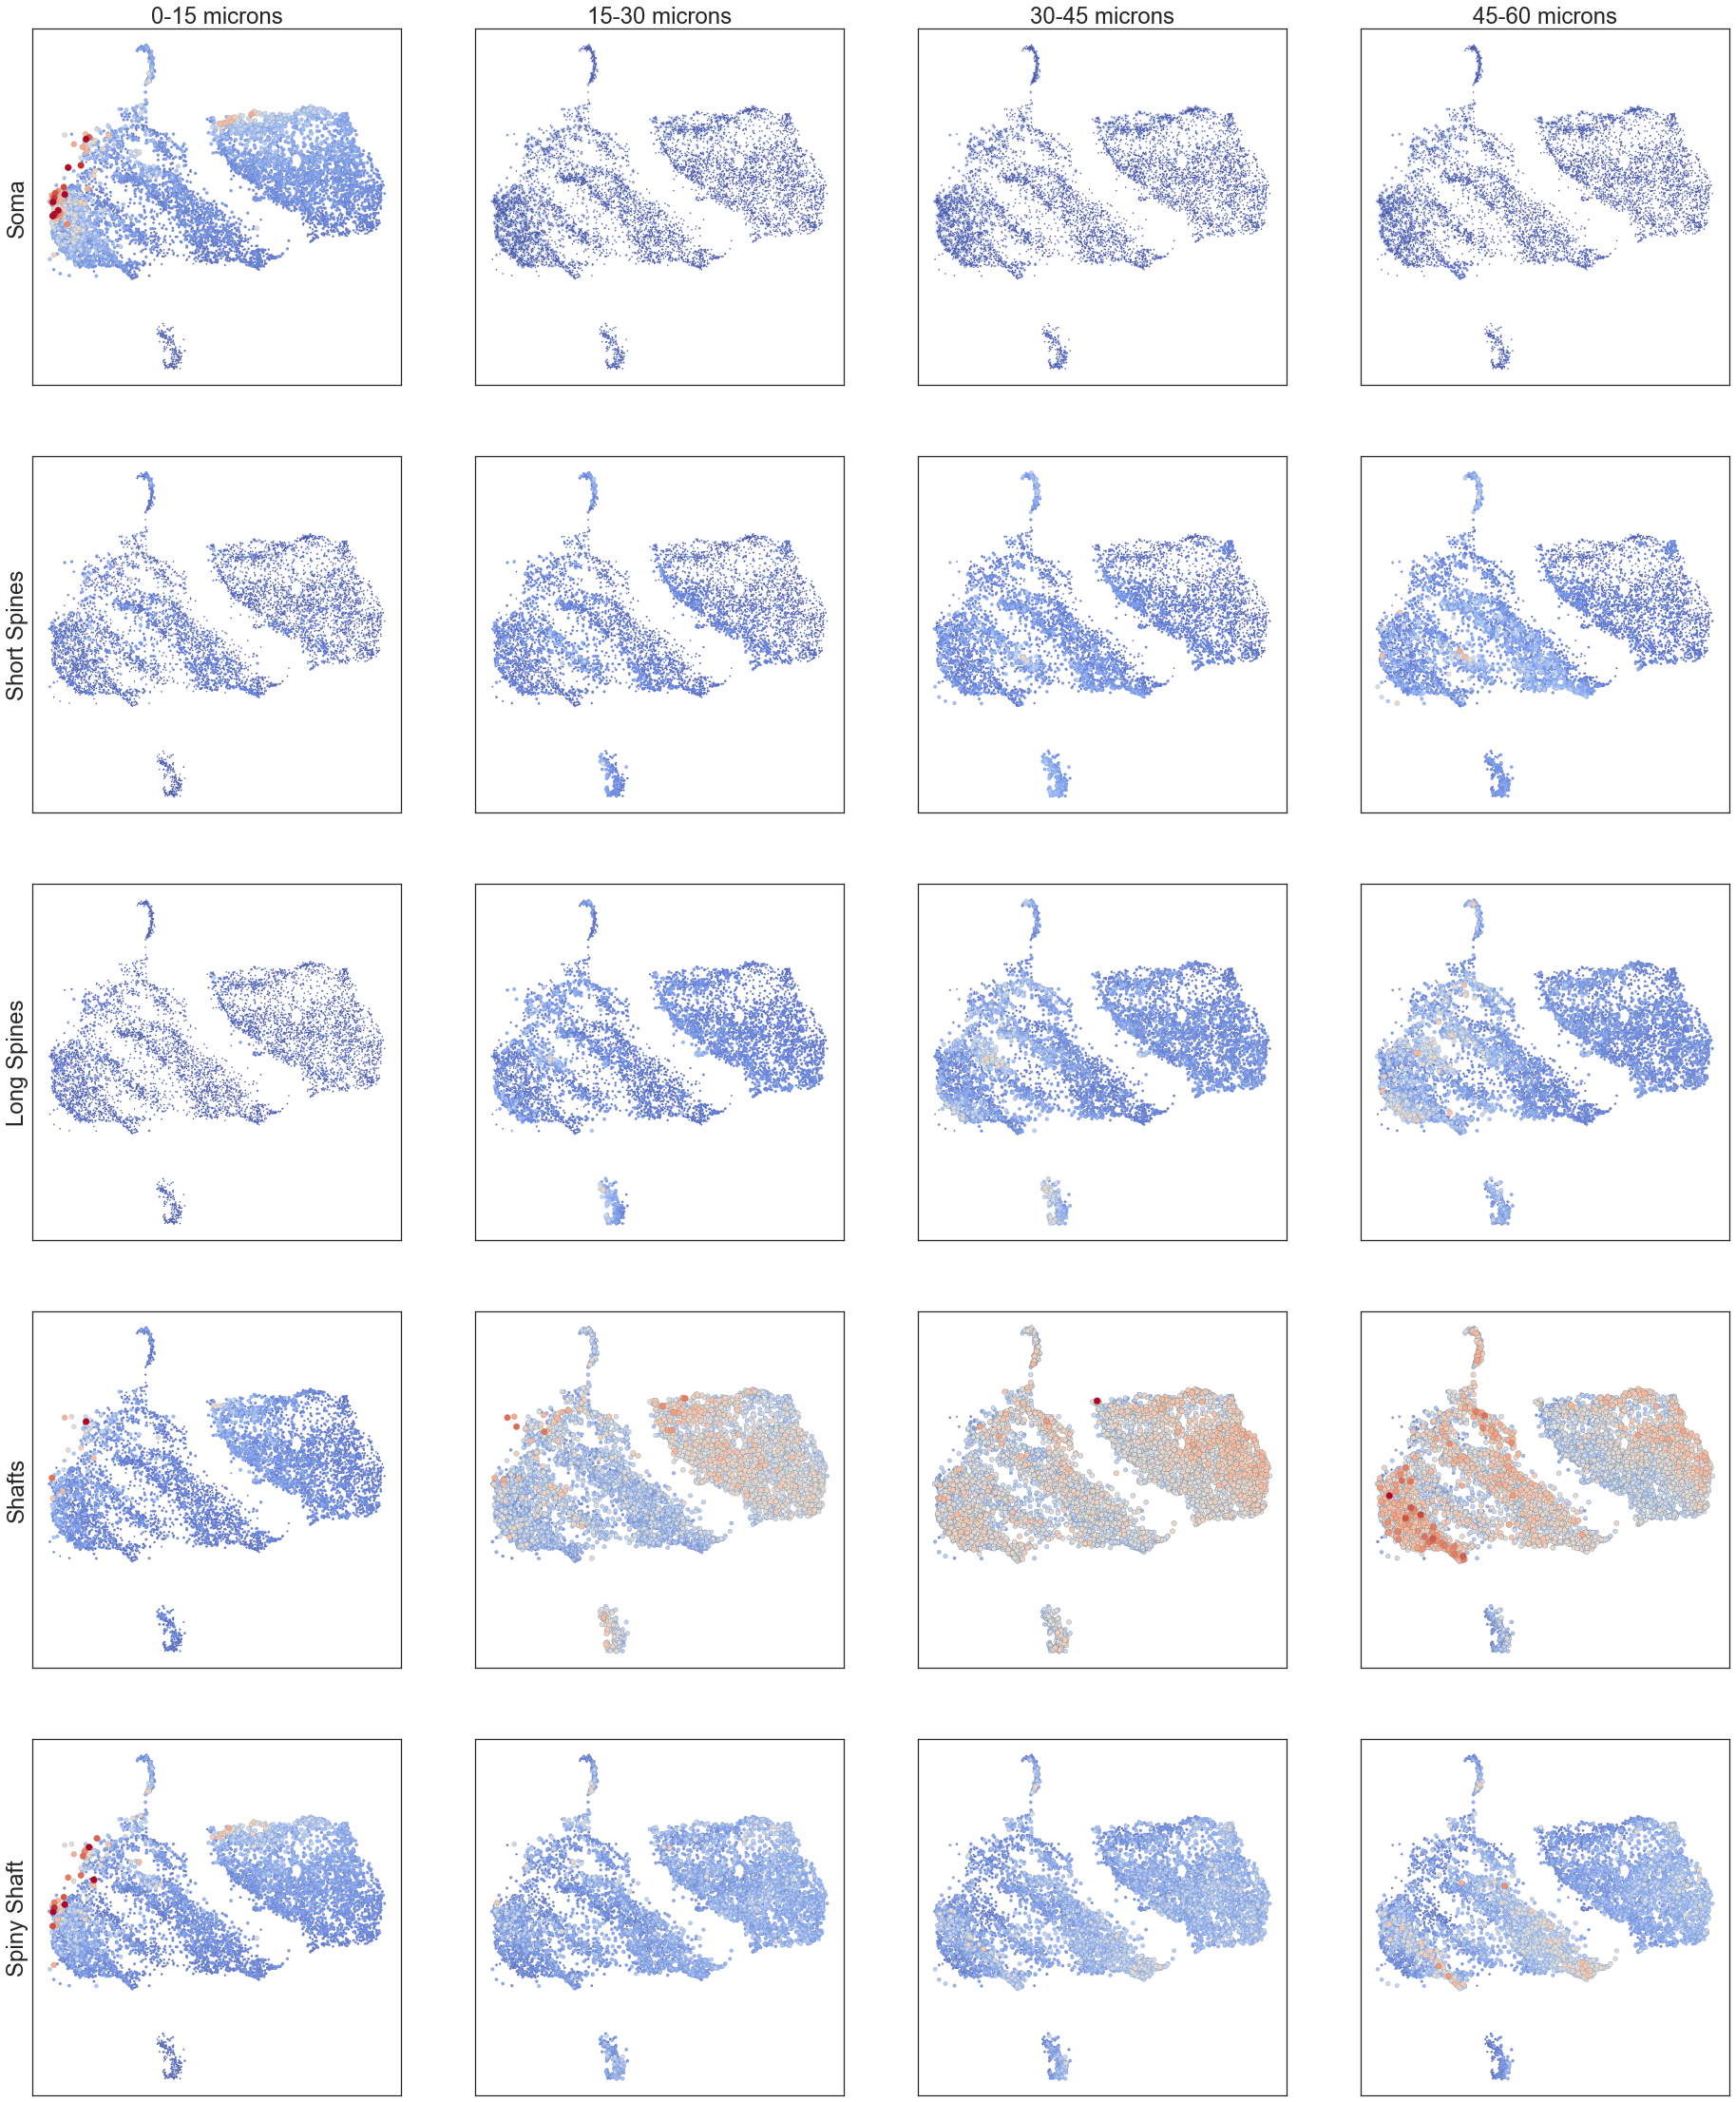

In [68]:
cols = 4
rows = 5
#label = command_dict[c]


#g = [pre] + post_bees
sns.set(style='white', font_scale =2)
fig, ax = plt.subplots(rows,cols, figsize=(8*cols,8*rows))

for ix,i in enumerate(shape_columns):
    #f, ax =plt.subplots(figsize=(11,11), facecolor='white')
    #ninety = np.percentile(minus[i], 99, axis=0)
    figx = math.floor(ix/cols)
    figy = ix%cols
    
    sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                    ax =ax[figx,figy],size=.1, alpha=0.2, palette = 'coolwarm',
                    data=norm_df[norm_df[i]==0], legend = False)
    
    sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                    ax =ax[figx,figy], sizes=(2,50),size=i, alpha=1.0, hue = i,hue_norm = (0,0.3), 
                    palette = 'coolwarm',size_norm=(0.01,0.3),
                    edgecolor='gray', data=norm_df.sort_values(i), legend = False)
    
    ax[figx,figy].set_xlabel('')
    ax[figx,figy].set_ylabel('')

    ax[figx,figy].set_xticks([])
    ax[figx,figy].set_yticks([])

#plot labels   
ax[0,0].set_ylabel('Soma', fontsize=24)
ax[1,0].set_ylabel('Short Spines', fontsize=24)
ax[2,0].set_ylabel('Long Spines', fontsize=24)
ax[3,0].set_ylabel('Shafts', fontsize=24)
ax[4,0].set_ylabel('Spiny Shaft', fontsize=24)


ax[0,0].set_title('0-15 microns', fontsize=24)
ax[0,1].set_title('15-30 microns', fontsize=24)
ax[0,2].set_title('30-45 microns', fontsize=24)
ax[0,3].set_title('45-60 microns', fontsize=24)
